# Practical 1: Optimisation

Contents:
* [1. Loading and Preparing the data](#1.-Loading-and-Preparing-the-data)
* [2. Logistic Regression Example](#2.-A-Single-Neuron-Logistic-Regression-Classifier)
* [3. Extra Considerations](#3.-Extra-Considerations)


Throughout this practical, we will be using the ```numpy``` package for calculations, which is designed for matrix multiplication. We will therefore be working with all of the data in vectorised form.

Look out for the following throughout the practical:

✅ To do: places where you need to add code throughout. Make sure that you understand what is going on before moving on to the next stage.

🏥 Indicates particular considerations when working with medical imaging data.


In [117]:
# Import dependencies
# Here we load the packages that we need for the rest of the practical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

## 1. Loading and Preparing the data
One of the most vital considerations when using deep learning for medical imaging is understanding the dataset we are working with. Without understanding the data, we will struggle to create good models and will not be able to evaluate their performance appropriately.

## 1.1 Loading the data
The first thing to do is to load the data. We are going to consider chest X-Ray images with two classes, pneumonia or healthy. Details about the data can be found [here](https://medmnist.com/).

Preparing our data is a vital stage in creating any network. We must:
* Eyeball the data to make sure it looks as expected
* Split the data into training / validation / test splits appropriately so that there is no leakage
* Preprocess the data so that it is in the appropriate form for the model

In this case, the data has been curated into a ```.npz``` file, and has already been split into train / val / test splits for us.
Label 0 = healthy, Label 1 = Pneumonia

**To do:**

✅ Identify how much data is available in each split

✅ Identify how much of each class is available. Very imbalanced numbers in classes is common but can make training networks a challenge.

✅ Visualise example of the images, using matplotlib, for both labels

In [118]:
!pwd

/Users/nathanewer/nwe/2_dlh/dlh_practical_jan26/healthcare_practicals/p1-Optimisation


In [119]:
# First we load the data
dataset = np.load(
    "/Users/nathanewer/nwe/2_dlh/dlh_practical_jan26/healthcare_practicals/data/pneumoniamnist.npz"
)
X_train, y_train = dataset["train_images"], dataset["train_labels"]
X_val, y_val = dataset["val_images"], dataset["val_labels"]
X_test, y_test = dataset["test_images"], dataset["test_labels"]

# Add your code below:

### How much data available in split:

In [120]:
# Data in each split

for f in dataset.files:
    print(f'{f}.shape: {dataset[f].shape}')

train_images.shape: (4708, 28, 28)
val_images.shape: (524, 28, 28)
test_images.shape: (624, 28, 28)
train_labels.shape: (4708, 1)
val_labels.shape: (524, 1)
test_labels.shape: (624, 1)


### How much of each class:

In [121]:
binclass = np.vstack((y_train, y_val,y_test))

In [122]:
np.unique(binclass, return_counts = True)

(array([0, 1], dtype=uint8), array([1583, 4273]))

### Visualise image data:

In [123]:
import pandas as pd

In [124]:
df = pd.DataFrame(map(lambda x: pd.Series(x.flatten()), [y_train, y_val, y_test])).T
df = df.rename(columns = {0: 'train_labels', 1: 'val_labels', 2: 'test_labels'})

In [173]:
df

,train_labels,val_labels,test_labels
0,1.0,1.0,1.0
1,1.0,1.0,0.0
2,1.0,1.0,1.0
3,1.0,0.0,0.0
4,1.0,1.0,1.0
...,...,...,...
4703,1.0,NaN,NaN
4704,1.0,NaN,NaN
4705,1.0,NaN,NaN
4706,0.0,NaN,NaN


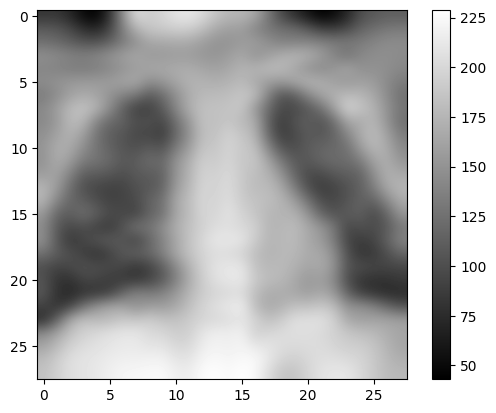

In [125]:
# Healthy example

plt.imshow(X_val[7], cmap="gray", interpolation="bicubic")
plt.colorbar()
plt.show()

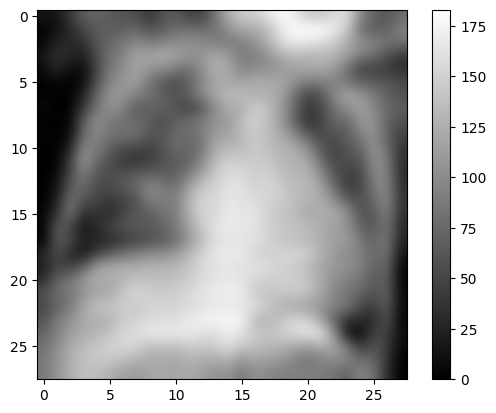

In [126]:
# Pneumonia example

plt.imshow(X_val[1], cmap="gray", interpolation = 'bicubic')
plt.colorbar()
plt.show()

🏥 Without medical training, it is difficult to tell whether the label given to an image is correct. Thus, we often have to trust the labels we are given but must still eyeball the data and check that there is nothing obviously strange going on and that the images contain what we expect to see.

🏥 Considering the number of values for each label, we can see that there are many more examples with pneumonia than there are heathly subjects. This was unsurprising as the chest X-Ray was completed because of suspected pneumonia and it would be unethical to radiate someone without cause. What effect might this have on the generalisability of the model?

For logistic regression, this data now needs to be converted into vectorised form:

$\mathbf{X}$ has shape: $(m_{features} \times n_{examples})$

We also add a row of zeros to $\mathbf{X}$  to multiply by the bias term, $\mathbf{w}_0$. In your machine learning course, you may have created feature vectors by generating feature maps such as edges. Here we are using the intensity values as the input features, as is the case when using CNNs.

$\mathbf{y}$ has shape: $1 \times n_{examples}$

*How could this effect the generalisability of the model:*
- Dataset is unbalanced, therefore the model may overfit to the positive example

In [127]:
# This cell can only be run once, rerun the previous cell if you want to rerun the cell
X_train = X_train.reshape(X_train.shape[0], -1).T
X_train = np.concatenate((np.ones((1,X_train.shape[1])), X_train))   # Add a row of zeros for the bias term
y_train = y_train.reshape(1, y_train.shape[0])
print(X_train.shape, y_train.shape)

X_val = X_val.reshape(X_val.shape[0], -1).T
X_val = np.concatenate((np.ones((1,X_val.shape[1])),X_val))
y_val = y_val.reshape(1, y_val.shape[0])
print(X_val.shape, y_val.shape)

X_test = X_test.reshape(X_test.shape[0], -1).T
X_test = np.concatenate((np.ones((1,X_test.shape[1])),X_test))
y_test = y_test.reshape(1, y_test.shape[0])
print(X_test.shape, y_test.shape)

(785, 4708) (1, 4708)
(785, 524) (1, 524)
(785, 624) (1, 624)


- Here, (x,y) 2D image is converted to 1D vector by placing all rows tip to tail (as in MNIST)
- Then a row of zeroes is added to initialise the bias term (1 zero for each vector (28*28 is 784))
- np.reshape(a, newshape) - if newshape = -1, array flattened to 1D by rows
- Transpose is to make it m x n form (from samples x features to features x samples)

We also want to preprocess the data to make it suitable for training the network. The best way to do this will depend on the data and the network being used, but common practice is to centre the X data such that the intensity values have zero mean and unit standard deviation.

It is vital that the same preprocessing pipeline is applied to all subsets of the data.

In [128]:
X_train

array([[  1.,   1.,   1., ...,   1.,   1.,   1.],
       [ 92., 115., 149., ...,  86.,  14.,  60.],
       [108., 118., 146., ...,  97.,   0.,  59.],
       ...,
       [168., 183., 188., ..., 145.,  71., 189.],
       [154., 176., 169., ..., 136., 104., 184.],
       [139., 169., 157., ..., 129., 135., 177.]])

(785, 4708)
(785, 524)
(785, 624)


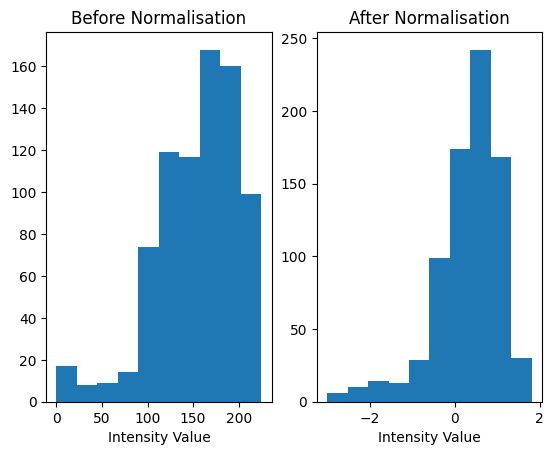

In [129]:
def centring(X):
    eps = 1e-7
    print(X.shape)
    mean = np.mean(X, axis = 1, keepdims= True)
    std = np.std(X, axis = 1, keepdims= True)
    return (X - mean) / (std + eps)

plt.subplot(1,2,1)
plt.hist(X_train[:,0])
plt.title('Before Normalisation')
plt.xlabel('Intensity Value')
X_train = centring(X_train)
plt.subplot(1,2,2)
plt.hist(X_train[:,0])
plt.title('After Normalisation')
plt.xlabel('Intensity Value')

X_val = centring(X_val)
X_test = centring(X_test)


In [174]:
print(X_train[:, 0].min())
print(X_train[:, 0].max())
print(X_train[:, 0].mean())
print(X_train[:, 0].std())

-3.0082767520566898
1.8215271232103651
0.33772203381784965
0.7808897072673041


Note the changed range of intensity values after normalisation.

- Do we expect a change in the underlying distribution?

# 2. A Single Neuron Logistic Regression Classifier
To understand how neural networks work, it serves to consider a single neuron as a logistic regression classifier:

![picture](https://drive.google.com/uc?id=14gUHAZriXSEIupy99k_n8bs09Je_rtwc)

Logistic regression can be considered as a very small neural network. Here the line $z =0$ defines a separating hyperplane, where the bias term $w_0$ has shifted this from the origin; all data points with $z >0$ are assigned to the positive class, and all data points with $z < 0$ are assigned to the negative class.

The vector $\mathbf{W}$ runs perpendicular to the line $z =0$ and defines the direction in which data classes are maximally separated when projected onto it.

Our predictions for a single input can be written:
$$ f= f(z) = \dfrac{1}{1+e^{-z}} $$

Where, for logistic regression, $f$ is the sigmoid function and:

$$z=w_0 + w_1x_1 + w_2x_2 +w_3x_3....+w_m x_m$$

Here $w_0$ is the bias term, $w_1,w_2....w_m$ are the weights, $m$ is the number of features, and $\mathbf{x}$ is a single example (i.e. one column) from our training set $X \in \mathbb{R}^{m\times n}$ .

✅ What are m and n in our case? Make sure you are happy with this.

**Implementation of the forward pass:**

We could calculate $f$ in one line of code, but it will come in handy when considering backpropagation later to consider the computation in stages, with each stage consisting of a simple module:

$$
\begin{align}
\mathbf{Z} &= \mathbf{W} \mathbf{X} \\
\mathbf{F}=f(\mathbf{Z}) &= \dfrac{1}{1+e^{-\mathbf{Z}}}
\end{align}
$$



- In this case, m is the number of features and n the number of samples == each m_i is a pixel in the original images, each n_i is an image

## 2.1 Initialise $\mathbf{W}$
We can now begin to construct our logistic regression. The first step is to initialise the weight matrix.

**To do:**

✅ Create a matrix of zeros to initialise $\mathbf{W}$ (note initialisation by zero is ok for a single neuron).

Hint: If $\mathbf{X}$ has shape $(m_{features} \times n_{examples})$, and we know that $\mathbf{Z}$ (and thus $\mathbf{F}$) should return _one_ scalar prediction _per example_, what shape should $\mathbf{W}$ be?

- Matrix multiplication valid for m . n x n . k, to give m . k array. 
- Therefore W has shape 1 x m

In [131]:
X_train.shape

(785, 4708)

In [132]:
# Add your code here:

W = np.zeros((1, 785))

## 2.2 Estimate $\mathbf{Z}$:

**To do**:

✅ Write a function $z(w,x)$ to linearly transform data matrix $\mathbf{X}$ using the weights matrix $\mathbf{W}$.

**Hint** implement $\mathbf{Z} = \mathbf{W} \mathbf{X}$; print out the shape - is it what you would expect?

In [133]:
def z(w,x):
    Z = w @ x
    return Z

Z = z(W,X_train)
print(Z.shape)

(1, 4708)


- Yes, this gives one scalar prediction per sample
- Matrix multiplication can be done with either a @ b or np.dot(a,b)

## 2.3 Implement Sigmoid function f:

**To do**:

✅  Now write a function to compute $f(\mathbf{Z})=\dfrac{1}{1+e^{-\mathbf{Z}}} $, our logistic regression function.

✅  Plot the function for a range of values (-5,5) to make sure it acts as expected.


In [134]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

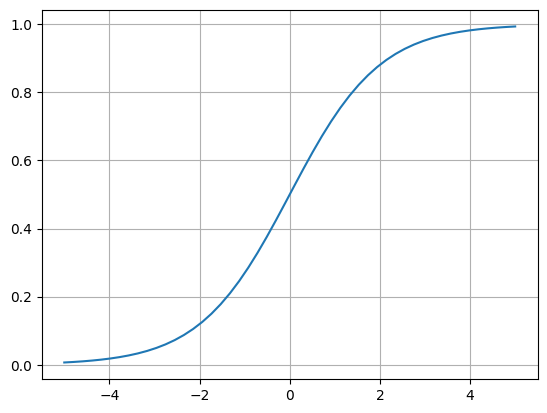

In [135]:
sigx = np.linspace(-5, 5)
sigy = sigmoid(sigx)

plt.plot(sigx, sigy)
plt.grid(True)
plt.show()

We can now compute some predictions $\mathbf{\hat{y}}$, and assess the performance of the model. We aren't expecting this to be very good as the weights are all zero!

In [136]:
y_pred = sigmoid(z(W,X_train))
print(y_pred.shape)
print(y_train.shape)

(1, 4708)
(1, 4708)


In [137]:
def accuracy(y, y_pred, threshold = 0.5):
    y_pred_thresholded = y_pred > threshold
    correct_predictions = np.sum(y==y_pred_thresholded)
    total_predictions = y.shape[1]
    accuracy = 100 * correct_predictions / total_predictions
    return accuracy

print(accuracy(y_train, y_pred))

25.78589634664401


**To do:**

✅ Look at the predictions ```y_pred```, what does this initial prediction return and why?

In [138]:
y_pred

array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]])

All 0.5, as W is all 0, so Z = WX is also all zero 

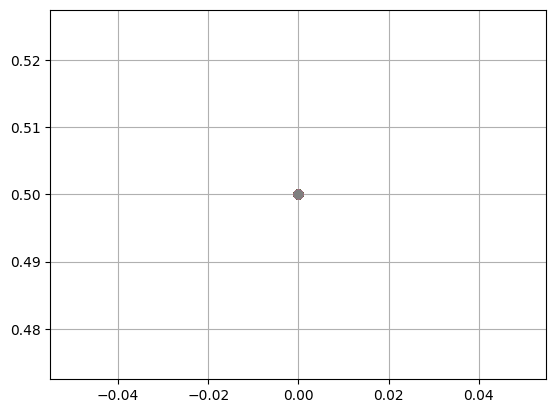

In [139]:
plt.plot(y_pred, 'o-')
plt.grid()
plt.show()

## 2.4 Implement Cross Entropy Loss
We now need to optimise the weights $w$ to give good performance.

Accuracy is easy to intepret, but can't be optimised using gradient descent. We need a measure of our prediction quality that can be optimised using gradient descent. A typical loss function used in  classification problems is cross-entropy:

$$L(y_i,f(z_i)) = - y_i \ln(f(z_i)) - (1-y_i) \ln(1-f(z_i))$$

This may be implemented using vectors as:

$$L(\mathbf{Y},\mathbf{F}) = - \mathbf{Y} \ln(\mathbf{F} + \epsilon) - (1-\mathbf{Y}) \ln(1-\mathbf{F} + \epsilon)$$

This returns a vector of losses $(L_1,L_2....L_n)$ estimated for all training examples n. The $\epsilon$ is added for numerical stability. We require the total cost estimated, as:

$$ J(\mathbf{W})= \frac{1}{n} \sum_i L_i(y_i,f(z_i)) $$

**To do**:

✅ Implement the Cross-Entropy loss and return the total cost, following the equation above.


In [147]:
# Implement loss function to calculate cross-entropy loss for all examples and average to return total cost
# note the negative sign so that the loss decreases as our predictions get better
def loss(y, y_pred):

    y = y.astype(float)

    eps = 1e-8
    cross_entropy = -y*np.log(y_pred - eps) - (1-y)*np.log(1- y_pred + eps)

    # double nested array with 1 element so [0]
    J = np.mean(cross_entropy[0])

    return J

In [148]:
total_loss = loss(y_train, y_pred)
print(total_loss)

0.6931471902455868


## 2.5 Computation Graph

Now we have our functions for $\mathbf{L}$ and $\mathbf{Z}$, and initialised $\mathbf{W}$, we are finally in a position to compute a forward and backward pass. Computation graphs can help us to achieve this by tracking the order of operations. The computation graph for logistic regression is:

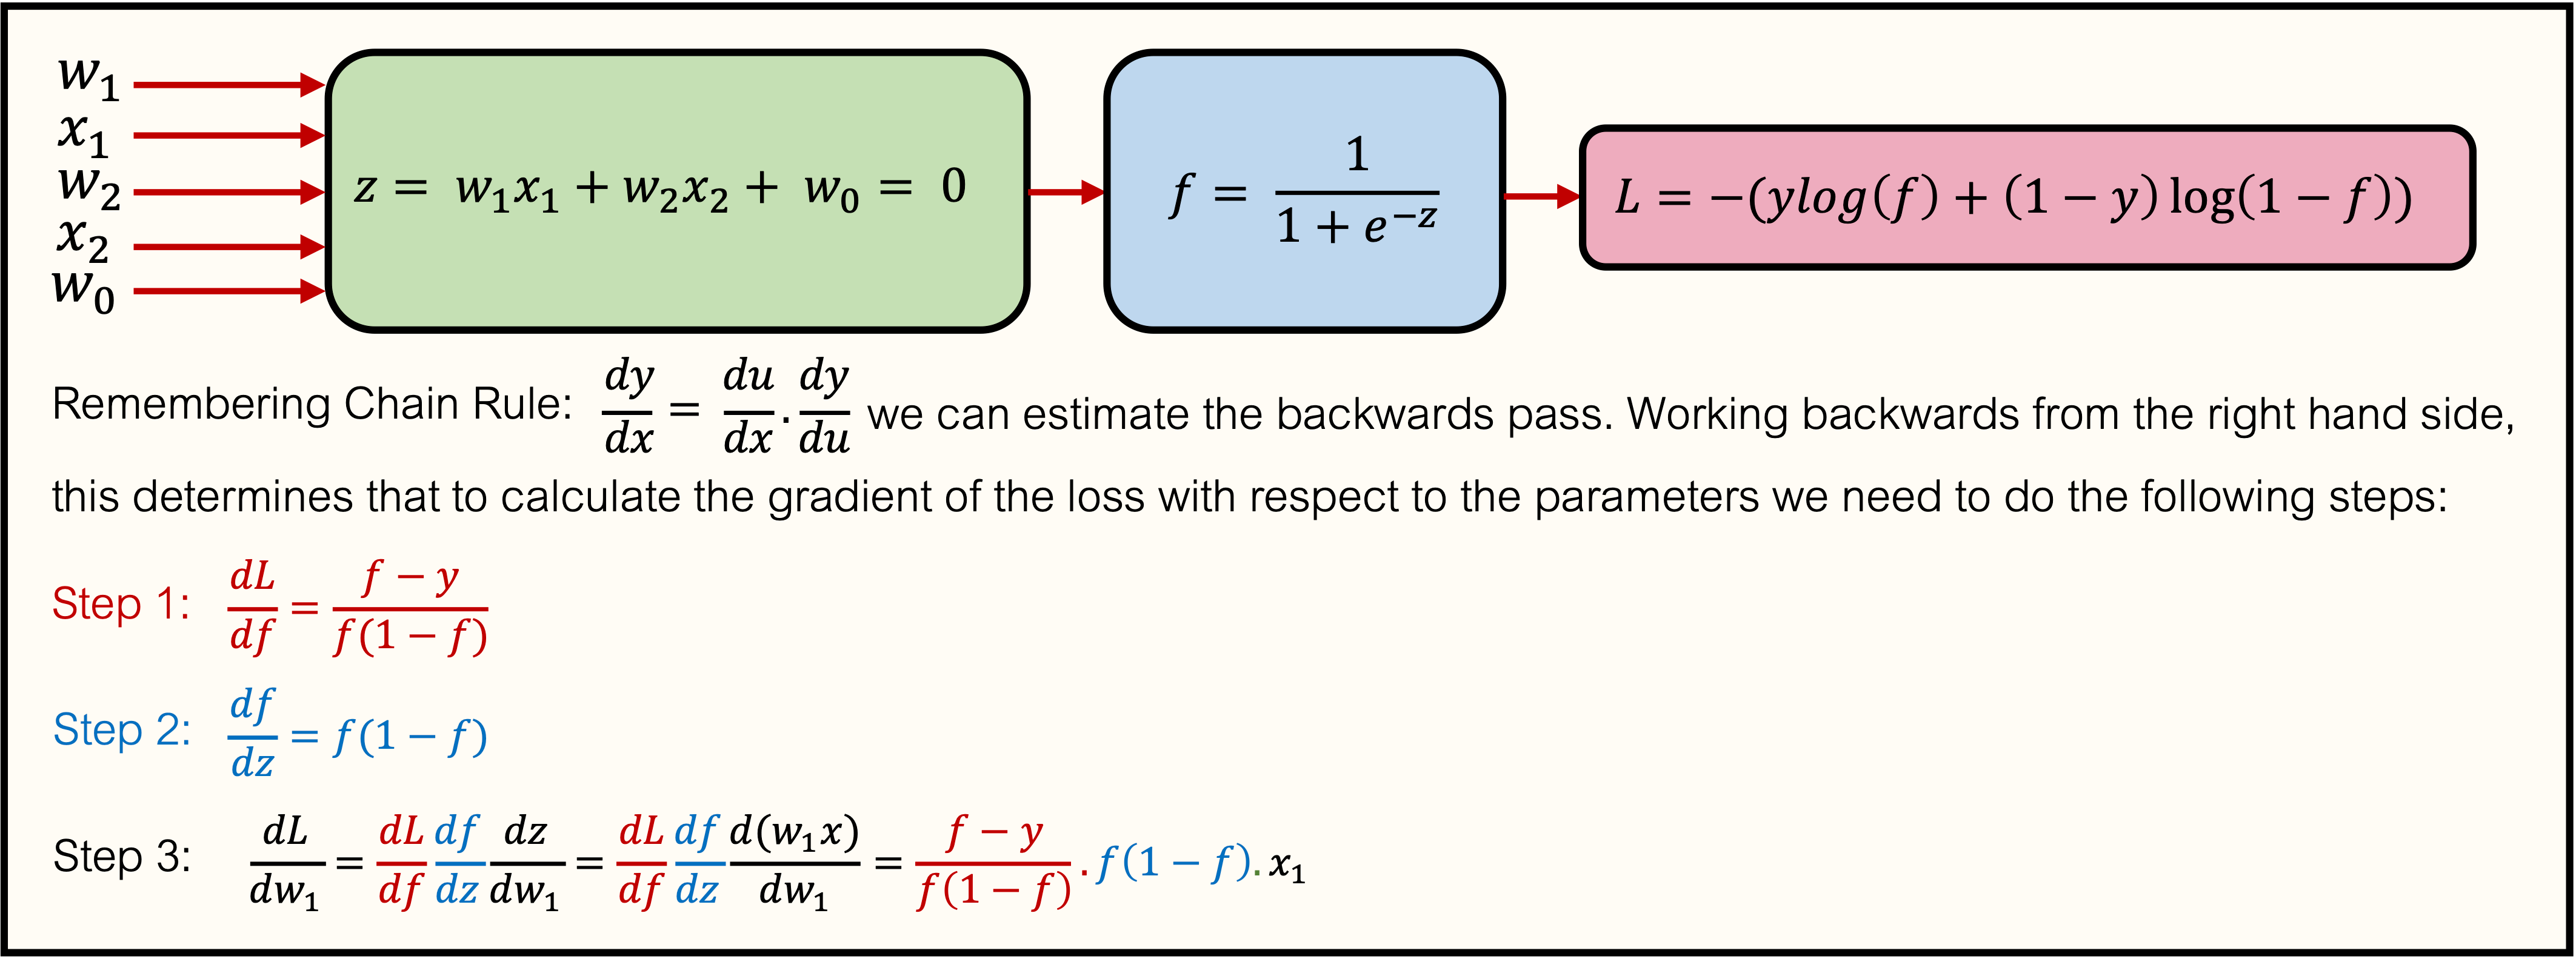

Don't forget that the full cost equates to the mean of the loss over all examples $J=\frac{1}{n_T}\sum_i L_I$ , $\dfrac{dJ}{dW}=\frac{1}{n_T} \sum_i \dfrac{dL_i}{dW} $ .

## 2.6 Implement the forward pass
We now have all the components of the forward pass for our logistic regression.

**To do**:

✅ Write a full forward pass that takes data, targets and a weight matrix and performs the forward pass, using vectors.

In [149]:
def forward_pass(X, y, W):

    y_pred = sigmoid(z(W,X)) # compute single neuron activation for layer L+1
    l = loss(y, y_pred)

    print('Loss: {}'.format(loss(y, y_pred)))
    print('Accuracy: {}'.format(accuracy(y ,y_pred)))
    return y_pred, l

y_pred, l = forward_pass(X_train,y_train, W)

Loss: 0.6991255803128137
Accuracy: 48.85301614273577


## 2.7 Implement the backwards pass
We're now ready to try to adjust our parameters $\mathbf{W}$ in order to optimise our predictions. To do this, we need to calculate the change in our loss function with respect to our parameters, $\dfrac{\partial L}{\partial \mathbf{W}}$.

Recalling our staged calculation of the logistic regression (in vectorised form):

$$
\mathbf{Z} = \mathbf{W} \mathbf{X} \\
\mathbf{F}= \dfrac{1}{1+e^{- \mathbf{Z}}} \\
\mathbf{L}  =  - \mathbf{Y} \ln(\mathbf{F}) - (1-\mathbf{Y}) \ln(1-\mathbf{F})
$$

We can write the vectorised gradients for each individual stage:

$$
\dfrac{\partial L}{\partial f} = \dfrac{\mathbf{F} - \mathbf{Y}}{\mathbf{F}(1-\mathbf{F})}\\
\dfrac{\partial f}{\partial z} = \mathbf{F}(1-\mathbf{F}) \\
\dfrac{\partial z}{\partial w} = \mathbf{X}^T
$$

And compose through the chain rule:

$$
\dfrac{\partial L}{\partial w} = \dfrac{\partial L}{\partial f} \cdot \dfrac{\partial f}{\partial z} \cdot\dfrac{\partial z}{\partial w} \\
\dfrac{\partial L}{\partial w} = \dfrac{\mathbf{F} - \mathbf{Y}}{\mathbf{F}(1-\mathbf{F})} \cdot \mathbf{F}(1-\mathbf{F}) \cdot \mathbf{X}^T
$$

Which can be simplified by cancelling $ \mathbf{F}(1-\mathbf{F})$ terms in both the numerator and the denominator:

$$ \dfrac{\partial L}{\partial w} = (\mathbf{F} - \mathbf{Y}) \mathbf{X}^T $$

Let's calculate the gradient of our loss, $\dfrac{\partial L}{\partial \mathbf{W}}$, for a **single** input, $\mathbf{x}$.

**To do:**

✅ Work through the equations above and be sure you are comfortable with all of the steps. Refer to 2.5 and the computation graph.

✅ Fill in the calculations of the backwards pass.

In [150]:
W = np.zeros((1,X_train.shape[0]))

# select just the first example here
x_single = X_train[:,0:1]
y_single = y_train[:,0:1]
print('The true value of y is: {}'.format(y_single))

# calculate the forward pass, and store the outputs at each stage
Z = z(W,x_single)
F = sigmoid(Z)
print('Our prediction for y is: {}'.format(F))

l = loss(y_single,F)
print('The loss is {}'.format(l))

# now enter the backwards pass here, implementing using the equations above:
dl_dw = (F - y_single) * x_single.T

print(dl_dw.shape,W.shape,x_single.shape)

The true value of y is: [[1]]
Our prediction for y is: [[0.5]]
The loss is 0.6931472005599455
(1, 785) (1, 785) (785, 1)


We can check if this gradient calculation is correct by updating our weights vector and looking at our new prediction:

In [151]:
# The gradient is in the direction of increasing loss, so we subtract the gradient from w.
W = W - 0.001 * dl_dw
Z = z(W,x_single)
F = sigmoid(Z)
l = loss(y_single,F)
print('Our updated prediction for y is: {}'.format(F))
print('The loss is {}'.format(l))

Our updated prediction for y is: [[0.57055334]]
The loss is 0.5611486316635798


Has the loss decreased? If not, check your answer. We have only updated $\mathbf{w}$ using information from a single data point. In practice, we want to use all of the data available for training. The following implements the gradient calculation for all data points. Make sure you understand what is happening here:

In [152]:
w = np.zeros((1,X_train.shape[0])) # We are now using all of the training data

# calculate the forward pass, and store the outputs at each stage
Z = z(w,X_train)
F = sigmoid(Z)
l = loss(y_train, F)

# To do - implement the backward pass
dl_dw = np.matmul((F-y_train),X_train.T)

print('dl_dw has shape: {}'.format(dl_dw.shape))

n_examples=X_train.shape[1]
grad_mean = dl_dw/n_examples

dl_dw has shape: (1, 785)



## 2.8 The training loop

We now have everything we need to train a logistic regression classifier using backprop.

**To do:**

✅ Create a training loop using the code from this practical so far.

✅ Plot the training curves to assess the training progression.

✅ Try changing the learning rate to see what effect this has on the training.

In [153]:
# initialise w to all zeros
w = np.zeros((1,X_train.shape[0]))
epsilon=1e-5

# we'll store the loss and accuracy in these lists during training
loss_record = []
accuracy_record = []

num_iterations = 100
learning_rate = 1e-2

for i in range(num_iterations):
    # forward pass - get predictions
    Z = z(w,X_train)
    F = sigmoid(Z)
    l = loss(y_train, F)

    # store the loss/ accuracy at this iteration
    accuracy_it=accuracy(y_train,F)
    loss_record.append(l)
    accuracy_record.append(accuracy_it)

    #backwards pass to get gradients
    dL_dw = np.matmul((F-y_train),X_train.T)
    grad_mean = dL_dw/X_train.shape[1]

    # update the weights
    w = w - learning_rate * grad_mean

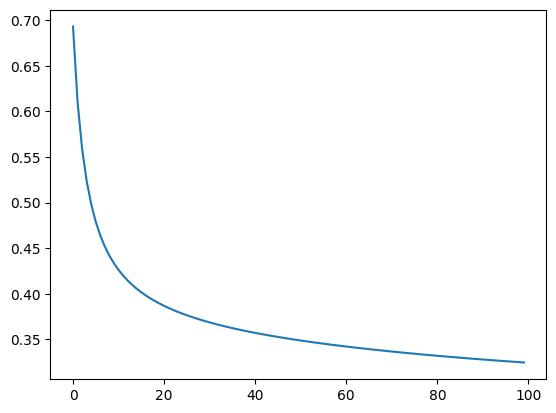

In [157]:
# Plot the training graphs using matplotlib

plt.plot(loss_record)
plt.show()

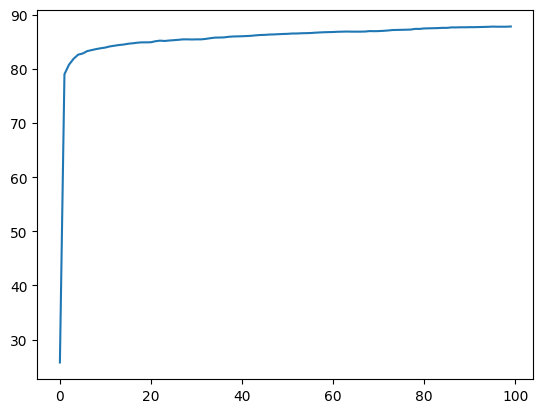

In [156]:
plt.plot(accuracy_record)
plt.show()

## 2.8 Testing on held out test set.

We now want to test our trained model on the test data. This data has not been seen by the model and it's important to report the performance on unseen data, rather than the data used to train the model.

In [158]:
Z_test = z(w,X_test)
F_test = sigmoid(Z_test)
l = loss(y_test,F_test)

print(l,accuracy(y_test,F_test))

0.37585621079100545 84.93589743589743


Not bad for such a simple model! Next week we will try ANNs/CNNs on the same data and see if we can improve the performance.

(Note the slight drop in performance from the training data. This is to be expected as this is unseen data, but if the drop is much larger it would suggest that the model has overfit to the training data. We will explore this more in future practicals.)

🏥 We have so far only evaluated the accuracy, but other metrics may be more important for medical applications. For instance, we may be most concerned about minimising the false negative (FN) rate.

**To do:**

✅ Implement a function to measure FN rate (remember Label 0 = healthy, Label 1 = Pneumonia)

In [172]:
def FN_rate(y, y_pred, threshold = 0.5):

    fn = 0
    tp = 0

    for i in range(len(y[0])):
        if (y[0][i] == 1) and (y_pred[0][i] > threshold):
            tp += 1
        elif (y[0][i] == 1) and (y_pred[0][i] < threshold):
            fn += 1

    FN_rate = fn / (fn + tp)

    return FN_rate

print(FN_rate(y_test, F_test))

0.15128205128205127


# 3. Extra Considerations

🏥 What is the differences between linear and logistic regression? Which would you expect to be most appropriate for the images we considered in this practical?

🏥 What would you expect to happen to model training if:
- The dataset became more imbalanced?
- The image size increased?

🏥 In this practical we used a threshold of 0.5 to binarise the prediction result. How else could we have selected the threshold?

🏥 In these examples we were able to optimise learning the whole dataset. If $N$, the number of training datapoints, is very large, this may not be possible. How does stochastic gradient descent allow us to train models?

🏥 Medical images are often very large and 3D. What effect is this likely to have on model training.

🏥 Explain when minimising the number of false negatives be critical?

🏥 What stategies might you employ to cope with the class imbalance in the dataset?

🏥 What is the difference between the sigmoid and softmax functions?

